In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms
import cv2 
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from google.colab import drive
import sys
from torchvision.ops import nms
from sklearn.utils import shuffle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# run GPU .... 
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Loading and filtering 

In [ ]:
def filterData(df):
  # this function filters the dataframe for filenames that have missing zeros and wrong typing of food names
  # input = dataframe
  # output = dataframe
  df['fileID'] = df['fileID'].apply(lambda x: '{0:0>6}'.format(x))
  df=df.replace("boiled potatoesw", "boiled potatoes")
  df=df.replace("chopped lettuce ","chopped lettuce")
  df=df.replace("glass of milk ","glass of milk")
  df=df.replace("slice of bread ","slice of bread")
  df=df.replace("meatballs","meatball")
  return df

In [ ]:
# def balance_data(df):
  
#   for t in range(10):
#     for i in range(df.loc[t].Nobj):
#       lableTemp = df["bbx_"+str(i)+"_name"]
      
#       allArraysL.append(lableTemp)

#   return df
# balance_data(df)
# print(df.loc[4].Nobj)

In [ ]:
# load csv file 
df = pd.read_csv('/content/drive/My Drive/train_anno_updated.csv')
df = filterData(df)
df = filterData(df)
df = shuffle(df)

df_val = pd.read_csv('/content/drive/My Drive/validation_anno_updated.csv')
df_val=filterData(df_val)
df_val = filterData(df_val)
df_val = shuffle(df_val)

In [ ]:
sys.path.append('/content/drive/My Drive')
from prepare_img import prepare_img
from anchorbox_generator import Anchorbox_generator
from class_rpn_vgg16 import ClassRPN, vgg16
from detection import Detection_Network
from nms_detection_loss import nms, sampleRoi
from bbox_predict import bbox_predict
from full_model import full_model
from loss import loss

cuda Tesla T4
cuda Tesla T4
cuda Tesla T4
cuda Tesla T4
cuda Tesla T4
cuda Tesla T4
cuda Tesla T4


In [ ]:
# total number of training data:
print('total number of training data: '+str(df.shape[0]))

total number of training data: 2032


#  Main Code with training:

In [ ]:
#train_data = np.loadtxt('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/ImageSets/Main/train.txt', dtype=int)
#train_data.astype(int)

train_iterations = 2032
iter_image = 1

train_total = iter_image*train_iterations

train_total_losses = np.zeros(train_total)
rpn_losses = np.zeros(train_total)
roi_losses = np.zeros(train_total)
rpn_cls_losses = np.zeros(train_total)
roi_cls_losses = np.zeros(train_total)
rpn_loc_losses = np.zeros(train_total)
roi_loc_losses = np.zeros(train_total)
train_iter = np.zeros(train_total)

# HYPERPARAMETERS
# learning rate
lr_rate = 0.00005
# weight decay
weight_decay = 0.0005
# momentum
momentum = 0.9
# the weight of the rpn_loc_loss in total rpn_loss
rpn_lambda = 1
# the weight of the rpn_loc_loss in total roi_loss
roi_lambda = 1
# The amount of samples in anchor_generation
anc_n_sample = 256
# The ratio of objects (not background) sampled in anchor_generation
anc_pos_ratio = 0.5
# The threshold for positive ious (foreground) in anchor_generations
anc_pos_iou_thresh = 0.9
# The threshold for negative ious (background) in anchor_generations
# if neither positive or negative then it is not used to train
anc_neg_iou_thresh = 0.3
# The amount of samples in sampleROI
n_sample = 128
# The ratio of objects (not background) sampled in sampleROI
pos_ratio = 0.25
# The threshold for positive ious (foreground) in sampleROI
pos_iou_thresh = 0.9
# The high threshold for negative ious (background) in smapleROI
neg_iou_thresh_hi = 0.3
# The low threshold for negative ious (background) in smapleROI
neg_iou_thresh_lo = 0.0
# Allowed overlapping area of bboxes in nms
nms_thresh = 0.7
# Amount of samples pre nms
n_train_pre_nms = 12000
# Amount of samples post nms
n_train_post_nms = 2000
# minimum size of bboxes in nms
min_size = 16

# validation iteration
val_iter = np.array([])
val_total_losses = np.array([])

criterion = nn.CrossEntropyLoss(ignore_index = -1)

# Complete network
# VGG16 = vgg16()
net = full_model()

# weight_decay is equal to L2 regularization
# optimizer = torch.optim.Adam(net.parameters(), lr=lr_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=lr_rate, momentum=momentum, weight_decay=weight_decay)

# lables of the food items as lib
lib_lab = {"meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}

it = 0 

for ii in range(train_iterations):
  # print(ii)
  if (ii)%5 == 0:
    print('Iteration: ', ii+1)
    print('Total iterations: ', it+1)

  # Validation
  if (ii+1)%10==0:
    n = (ii+1)%10
    # Prepare image, bbox and labels 
    img1 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(df_val.fileID.iloc[n])+'.jpg')
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
    # Select a row and transform back to pandas data frame
    temp = df_val.iloc[n]
    tt_val = temp.to_frame()
    tt_val = tt_val.T  

    # FORWARD
    out_val = net(img1, tt_val, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)

    # LOSS
    val_total_loss, val_rpn_loss, val_roi_loss, val_roi_cls_loss, val_roi_loc_loss, val_rpn_cls_loss, val_rpn_loc_loss= loss(out_val, criterion, rpn_lambda, roi_lambda)
    val_total_losses = np.append(val_total_losses, val_total_loss.detach().cpu().numpy())
    val_iter = np.append(val_iter, ii+1)

  # Prepare image, bbox and labels 
  img0 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(df.fileID.iloc[ii])+'.jpg')
  img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 
  # Select a row and transform back to pandas data frame
  temp = df.iloc[ii]
  tt = temp.to_frame()
  tt = tt.T


  for t in range(iter_image):
    # FORWARD
    # img = prepare_img(img0)
    # out_map = VGG16(img)
    out = net(img0, tt, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)


    # LOSS
    total_loss, rpn_loss, roi_loss, roi_cls_loss, roi_loc_loss, rpn_cls_loss, rpn_loc_loss = loss(out, criterion, rpn_lambda, roi_lambda)


    rpn_losses[it] = rpn_loss
    roi_losses[it] = roi_loss
    rpn_cls_losses[it] = rpn_cls_loss
    roi_cls_losses[it] = roi_cls_loss
    rpn_loc_losses[it] = rpn_loc_loss
    roi_loc_losses[it] = roi_loc_loss
    train_total_losses[it] = total_loss
    train_iter[it] = it+1
    it = it+1

    # BACKWARD RPN
    # optimizer_RPN.zero_grad()
    # rpn_loss.backward()
    # optimizer_RPN.step()


    # BACKWARD RoI/detection
    # optimizer_DN.zero_grad()
    # roi_loss.backward()
    # optimizer_DN.step()

    # BACKWARD
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  




Iteration:  1
Total iterations:  1
Iteration:  6
Total iterations:  6
Iteration:  11
Total iterations:  11
Iteration:  16
Total iterations:  16
Iteration:  21
Total iterations:  21
Iteration:  26
Total iterations:  26
Iteration:  31
Total iterations:  31
Iteration:  36
Total iterations:  36
Iteration:  41
Total iterations:  41
Iteration:  46
Total iterations:  46
Iteration:  51
Total iterations:  51
Iteration:  56
Total iterations:  56
Iteration:  61
Total iterations:  61
Iteration:  66
Total iterations:  66
Iteration:  71
Total iterations:  71
Iteration:  76
Total iterations:  76
Iteration:  81
Total iterations:  81
Iteration:  86
Total iterations:  86
Iteration:  91
Total iterations:  91
Iteration:  96
Total iterations:  96
Iteration:  101
Total iterations:  101
Iteration:  106
Total iterations:  106
Iteration:  111
Total iterations:  111
Iteration:  116
Total iterations:  116
Iteration:  121
Total iterations:  121
Iteration:  126
Total iterations:  126
Iteration:  131
Total iteratio

In [ ]:
print(roi_loss, rpn_loss)
print(roi_cls_loss, roi_loc_loss)
print(rpn_cls_loss, rpn_loc_loss)

tensor(0.0015, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0523, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0., device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)
tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.0197, device='cuda:0', dtype=torch.float64, grad_fn=<CopySlices>)


In [ ]:
VGG16 = vgg16()
RPN = ClassRPN()
DETECTION = Detection_Network()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(VGG16))
print(count_parameters(RPN))
print(count_parameters(DETECTION))
print(count_parameters(net))

14714688
2387510
119771191
136873389


In [ ]:
# parameters = 0
# print(net.parameters)
# for parameter in net.parameters():
#     print(parameter.numel())
#     #print(parameter)
#     parameters = parameters + parameter.numel()
# print('Total weights:')
# print(parameters)

# train loss plot

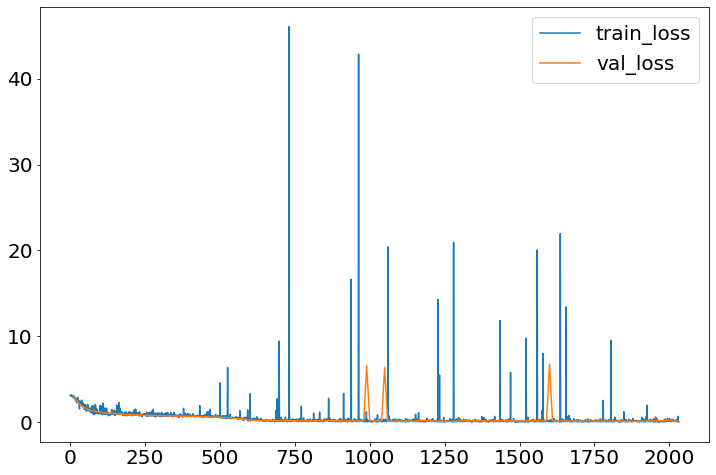

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, train_total_losses, label='train_loss')
plt.plot(val_iter, val_total_losses, label='val_loss')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

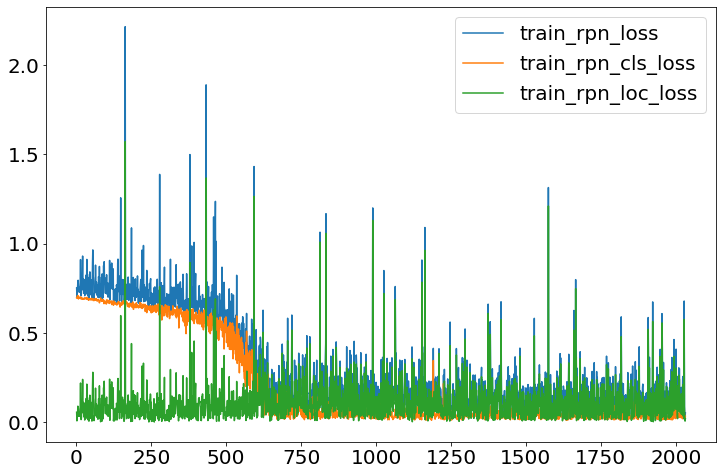

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, rpn_losses, label='train_rpn_loss')
plt.plot(train_iter, rpn_cls_losses, label='train_rpn_cls_loss')
plt.plot(train_iter, rpn_loc_losses, label='train_rpn_loc_loss')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

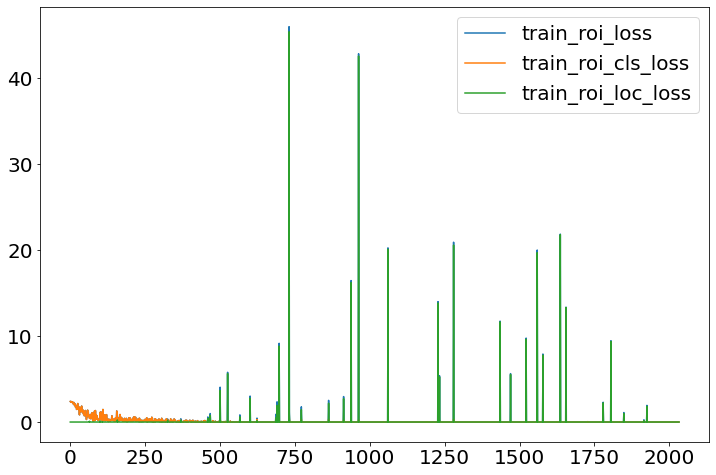

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(train_iter, roi_losses, label='train_roi_loss')
plt.plot(train_iter, roi_cls_losses, label='train_roi_cls_loss')
plt.plot(train_iter, roi_loc_losses, label='train_roi_loc_loss')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# Test code

# Classification: 
Taking region of interest score (tensor) as input and calculates for each row the biggest score for each class. 
Returns a score list of which classes has been most presented in the roi_cls_score

[2 2 2 2 3]
slice of bread
0.23485015
slice of bread
0.2202331
slice of bread
0.21987203
slice of bread
0.21824174
boiled potatoes
0.21556175


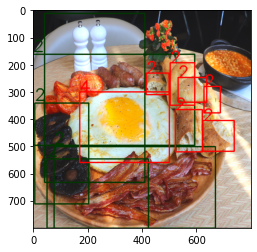

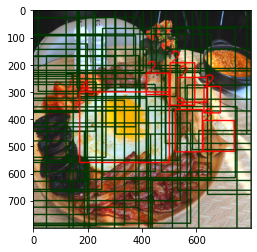

In [ ]:
# import importlib
# import bbox_predict #import the module here, so that it can be reloaded.
# importlib.reload(bbox_predict)
# from bbox_predict import bbox_predict
# importlib.reload(bbox_predict)
#test 
test_data=pd.read_csv('/content/drive/My Drive/test_anno_updated.csv')
test_data=filterData(test_data)
imageIndex = 25
img0 = cv2.imread('/content/drive/My Drive/DL-projekt/VOCdevkit/VOC2007/JPEGImages/'+str(test_data.fileID.iloc[imageIndex])+'.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) 

 
# Select a row and transform back to pandas data frame
temp = test_data.iloc[imageIndex]
tt = temp.to_frame()
tt = tt.T

# bounding box true value for the image of choice and lables for bounding boxes
allArrays = []
allArraysL = [] 
labels1 = []
label= []
bbox = []
for i in range(tt.Nobj.values[0]):
  p_temp = tt[['bbx_'+str(i)+'_ymin','bbx_'+str(i)+'_xmin','bbx_'+str(i)+'_ymax','bbx_'+str(i)+'_xmax']].to_numpy()
  allArrays.append(p_temp)
  lableTemp = tt["bbx_"+str(i)+"_name"].map(lib_lab)
  allArraysL.append(lableTemp)
#[ymin, xmin, ymax, xmax] bounding box 
bbox0 = np.vstack(allArrays)
bbox0 = bbox0.astype(int)
label = np.vstack(allArraysL)

# change the bounding box coordinates 
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox0 = np.array(bbox)

# lables are stored as int in lib_lab and mapped into int 
labels1 = label.reshape(-1)

lib_lab = {"background": 0, "meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}

remove_background = True
# img = prepare_img(img0)
# out_map = VGG16(img)
img, roi_loc_pred, score, labels, roi, anchors = net.predict(img0, nms_thresh=0.5, n_test_pre_nms=100, n_test_post_nms=5, min_size=16, remove_background=remove_background)
img_clone = np.copy(img)
img_clone2 = np.copy(img)

if remove_background:
  lib_lab = {"meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}


out = net(img0, tt, anc_n_sample = anc_n_sample, n_sample = n_sample, anc_pos_ratio = anc_pos_ratio, pos_ratio = pos_ratio, pos_iou_thresh = pos_iou_thresh, anc_pos_iou_thresh = anc_pos_iou_thresh, anc_neg_iou_thresh = anc_neg_iou_thresh, neg_iou_thresh_hi=neg_iou_thresh_hi, neg_iou_thresh_lo=neg_iou_thresh_lo, nms_thresh = nms_thresh, n_train_pre_nms = n_train_pre_nms, n_train_post_nms = n_train_post_nms, min_size = min_size)

pos_index, neg_index, gt_roi_locs, gt_roi_labels, sample_roi, pos_roi_per_this_image = out['sampleROI']
roi = out['nms']
pred_anchor_locs, objectness_score, pred_cls_scores = out['RPN']

print(labels+1)

# Show final bboxes and labels
for i in range(len(roi_loc_pred[:,1])):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels[i]+1)]
    print(label)
    print(score[i])
    y0, x0, y1, x1 = roi_loc_pred[i].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)
    cv2.putText(img_clone, str(labels[i]+1), (x0, y0-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 55, 0),thickness=4)
    #cv2.putText(img_clone, str(score[i]), (x0, y1+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),thickness=3)
# Show groundtruth and label
lib_lab = {"background": 0, "meatball": 1, "slice of bread": 2, "boiled potatoes":3, "fried egg":4,"glass of water":5, "chopped lettuce":6, "glass of milk":7, "boiled peas":8,"plain spaghetti":9, "plain rice":10}
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone)
plt.show()

# Show region proposals
for i in range(50):
    y0, x0, y1, x1 = roi[i].astype(int)
    cv2.rectangle(img_clone2, (x0, y0), (x1, y1), color=(0, 55, 0), thickness=3)

# Show groundtruth and label
for i in range(len(bbox0)):
    label = list(lib_lab.keys())[list(lib_lab.values()).index(labels1[i])]
    cv2.rectangle(img_clone2, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0, 0), thickness=3) 
    cv2.putText(img_clone2, str(labels1[i]), (bbox0[i][1], bbox0[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0),thickness=3) 

plt.imshow(img_clone2)
plt.show()
